In [2]:
import cellrank as cr
import scanpy as sc
import anndata as ad
import numpy as np

#from moscot.problems.time import TemporalProblem
sc.settings.set_figure_params(frameon=False, dpi=200)
cr.settings.verbosity = 2
import warnings
warnings.simplefilter("ignore", category=UserWarning)
cr.settings.figdir=''
sc.settings.figdir=''
sc.settings.plot_prefix=''
import scvelo as scv
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.figdir= ''
scv.settings.plot_prefix=''
print('import successful')

Running scvelo 0.3.2 (python 3.10.15) on 2024-12-06 14:20.
import successful


In [52]:
###global variable###
dataset = 'S-AG'
cores = 8
terminal_states = ["LumSEC-Lip","LumSEC-MG-like",'LumSEC-Hmgcr','Lum-Krt8','Lum-Ppl']
initial_state='ASC'
n_genes = 50
pseudotime='palantir_pseudotime' #'palantir_pseudotime' or 'dpt_pseudotime'
n_states=[4,12]##macrostates##
cr.settings.n_jobs=cores

######################

In [3]:
#adata_clean = ad.read_h5ad(f'../1.subset/{dataset}_cleaned.h5ad')
adata_velo = ad.read_h5ad(f'../2.scvelo/{dataset}_velofinished.h5ad')
adata_pala = ad.read_h5ad(f'../3.palantir/{dataset}.palantir_finished.h5ad')
#adata_clean = ad.read_h5ad(f'D:/111/{dataset}_cleaned.h5ad')
#adata_velo = ad.read_h5ad(f'D:/111/{dataset}_velofinished.h5ad')
#adata_pala = ad.read_h5ad(f'D:/111/{dataset}.palantir_finished.h5ad')

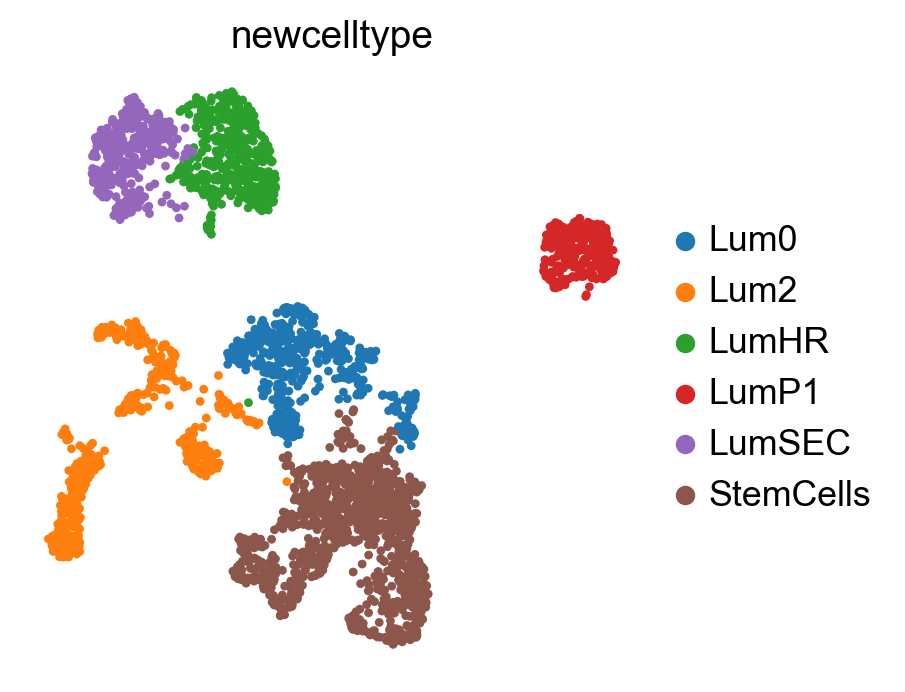

In [5]:
sc.pl.embedding(adata_pala, basis="umap", color="newcelltype")

In [6]:
vk = cr.kernels.VelocityKernel(adata_velo,n_jobs=cores)
vk.compute_transition_matrix(n_jobs=cores)
print(vk)

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3000 [00:00<?, ?cell/s]

Using `softmax_scale=17.5409`


  0%|          | 0/3000 [00:00<?, ?cell/s]

    Finish (0:00:16)


NameError: name 'k' is not defined

In [7]:
pk = cr.kernels.PseudotimeKernel(adata_pala, time_key=pseudotime,n_jobs=cores)
pk.compute_transition_matrix(n_jobs=cores)
print(pk)

Computing transition matrix based on pseudotime


  0%|          | 0/3000 [00:00<?, ?cell/s]

    Finish (0:00:01)
PseudotimeKernel[n=3000]


In [ ]:
'''
tp = TemporalProblem(adata_velo,n_jobs=cores)
tp = tp.prepare(time_key="time",n_jobs=cores)
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean",n_jobs=cores)
tmk = RealTimeKernel.from_moscot(tp,n_jobs=cores)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto",n_jobs=cores)
print(tmk)
'''

In [8]:
####combined kernels####
cbk = 0.2* pk + 0.8 * vk 

In [ ]:
####GPCCA，Generalized Perron Cluster Cluster Analysis####

In [9]:
g = cr.estimators.GPCCA(cbk)
print(g)

GPCCA[kernel=(0.5 * PseudotimeKernel[n=3000] + 0.5 * VelocityKernel[n=3000]), initial_states=None, terminal_states=None]


In [22]:
len(adata_pala.obs['newcelltype'].unique())

6

In [34]:
g.fit(cluster_key="newcelltype",n_states=n_states)##macrostates##

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:37)
Calculating minChi criterion in interval `[4, 12]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:31)


GPCCA[kernel=(0.5 * PseudotimeKernel[n=3000] + 0.5 * VelocityKernel[n=3000]), initial_states=None, terminal_states=None]

In [ ]:
cr.settings.figdir=''
sc.settings.figdir=''

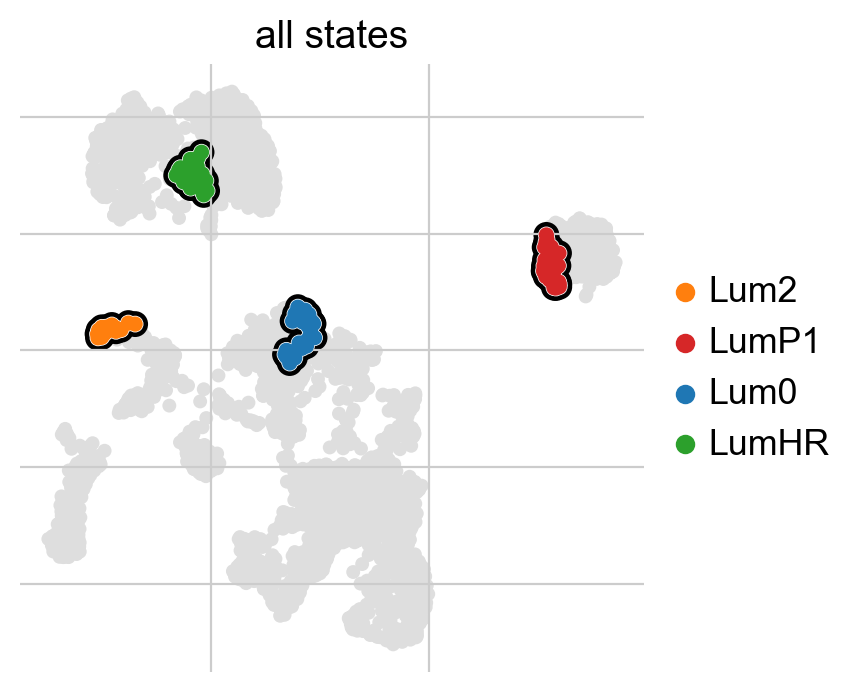

In [36]:
g.plot_macrostates(which="all", legend_loc="right", s=100,save=f'{dataset}-all-macrostates.png')

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


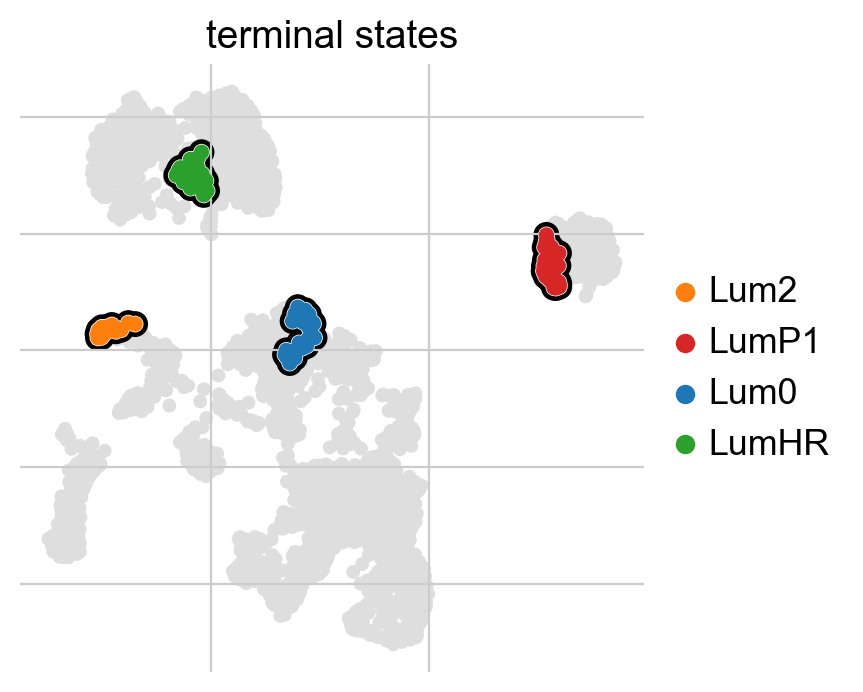

In [37]:
g.set_terminal_states(states=terminal_states)
g.plot_macrostates(which="terminal", legend_loc="right", size=100,save=f'{dataset}-terminal-macrostates.png')

In [ ]:
g.set_initial_states(states=initial_state)
g.plot_macrostates(which="initial", legend_loc="right", s=100,save=f'{dataset}-initial-macrostates.png')

In [ ]:
####fate_probabilities####

Computing fate probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
saving figure to file ../M-MG-fate_probabilities.png


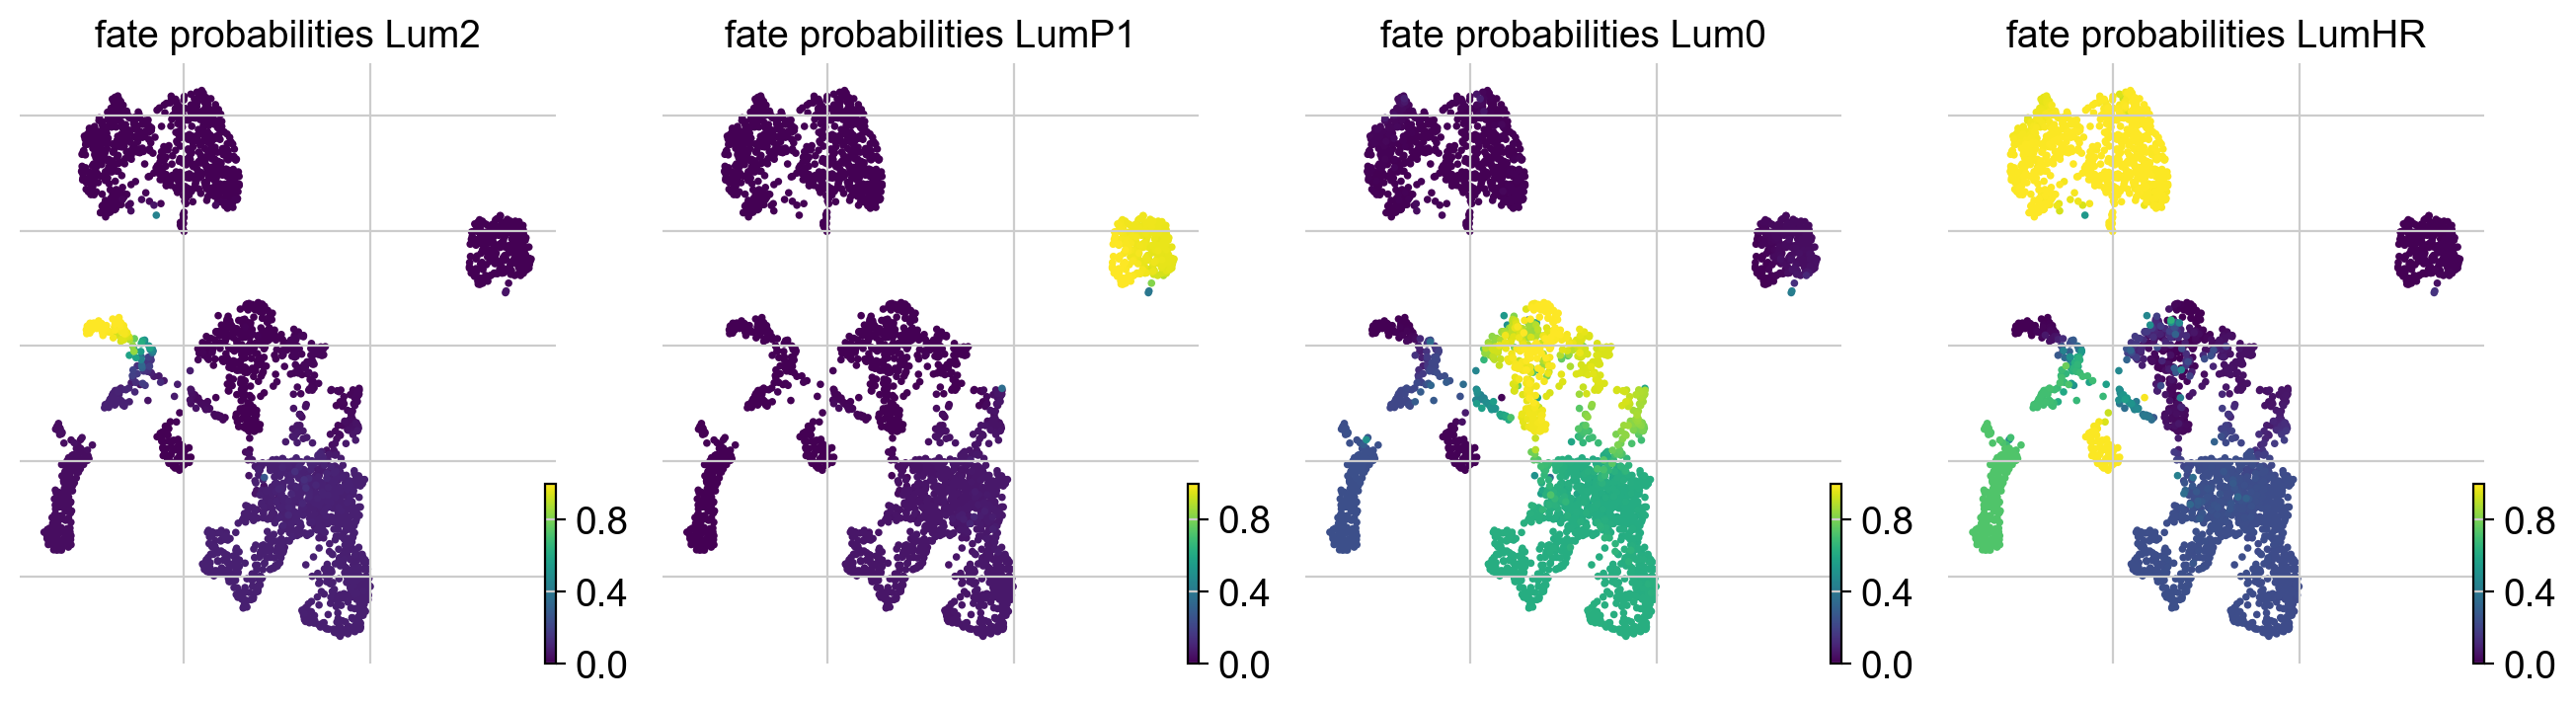

In [59]:
g.compute_fate_probabilities(n_jobs=cores)
g.plot_fate_probabilities(same_plot=False,save=f'{dataset}-fate_probabilities.png')

saving figure to file ./figures/scvelo_M-MG-666.png


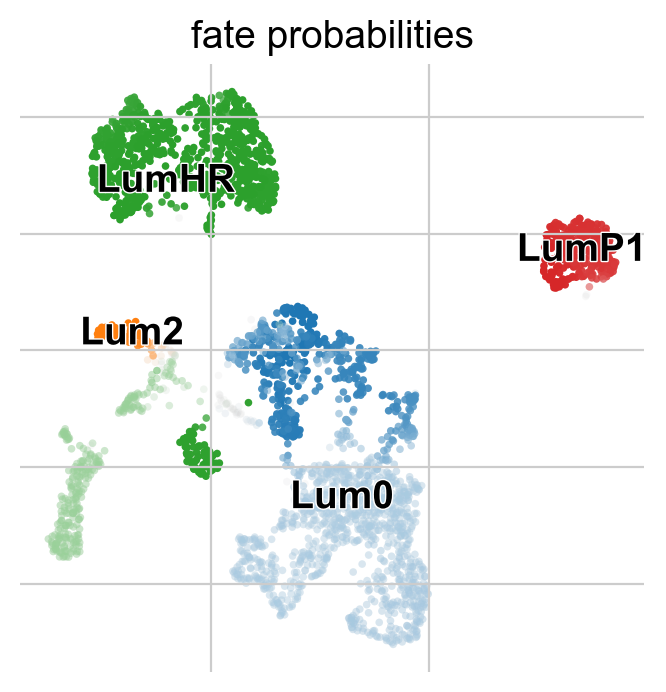

In [58]:
g.plot_fate_probabilities(same_plot=True,save=f'{dataset}-celltype-fate_probabilities.png')

In [ ]:
for cellname in terminal_states:
    delta_df = g.compute_lineage_drivers(
    lineages=[cellname], cluster_key="newcelltype",n_jobs=cores
    )
    delta_df.head(10)
    adata_pala.obs[f"fate_probabilities_{cellname}"] = g.fate_probabilities[cellname].X.flatten()
    sc.pl.embedding(
    adata_pala,
    basis="umap",
    color=[f"fate_probabilities_{cellname}"] + list(delta_df.index[:8]),
    color_map="viridis",
    s=50,
    ncols=3,
    vmax="p96",save=f'{dataset}-{cellname}-driver-genes.png'
)

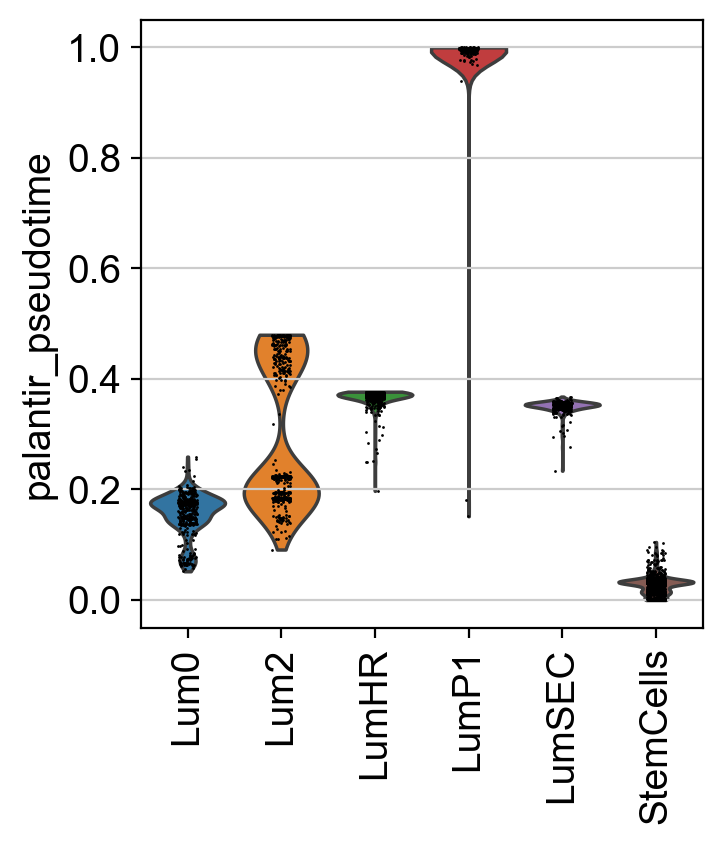

In [42]:
sc.pl.violin(adata_pala, keys=[pseudotime], groupby="newcelltype", rotation=90,save=f'{dataset}-violin.png')

In [ ]:
####pseudotime heatmap####

In [47]:
model = cr.models.GAM(adata_pala,n_knots=cores )

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Computing trends using `4` core(s)


  0%|          | 0/40 [00:00<?, ?gene/s]

    Finish (0:00:27)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Computing trends using `4` core(s)


  0%|          | 0/40 [00:00<?, ?gene/s]

    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Computing trends using `4` core(s)


  0%|          | 0/40 [00:00<?, ?gene/s]

    Finish (0:00:06)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Computing trends using `4` core(s)


  0%|          | 0/40 [00:00<?, ?gene/s]

    Finish (0:00:52)


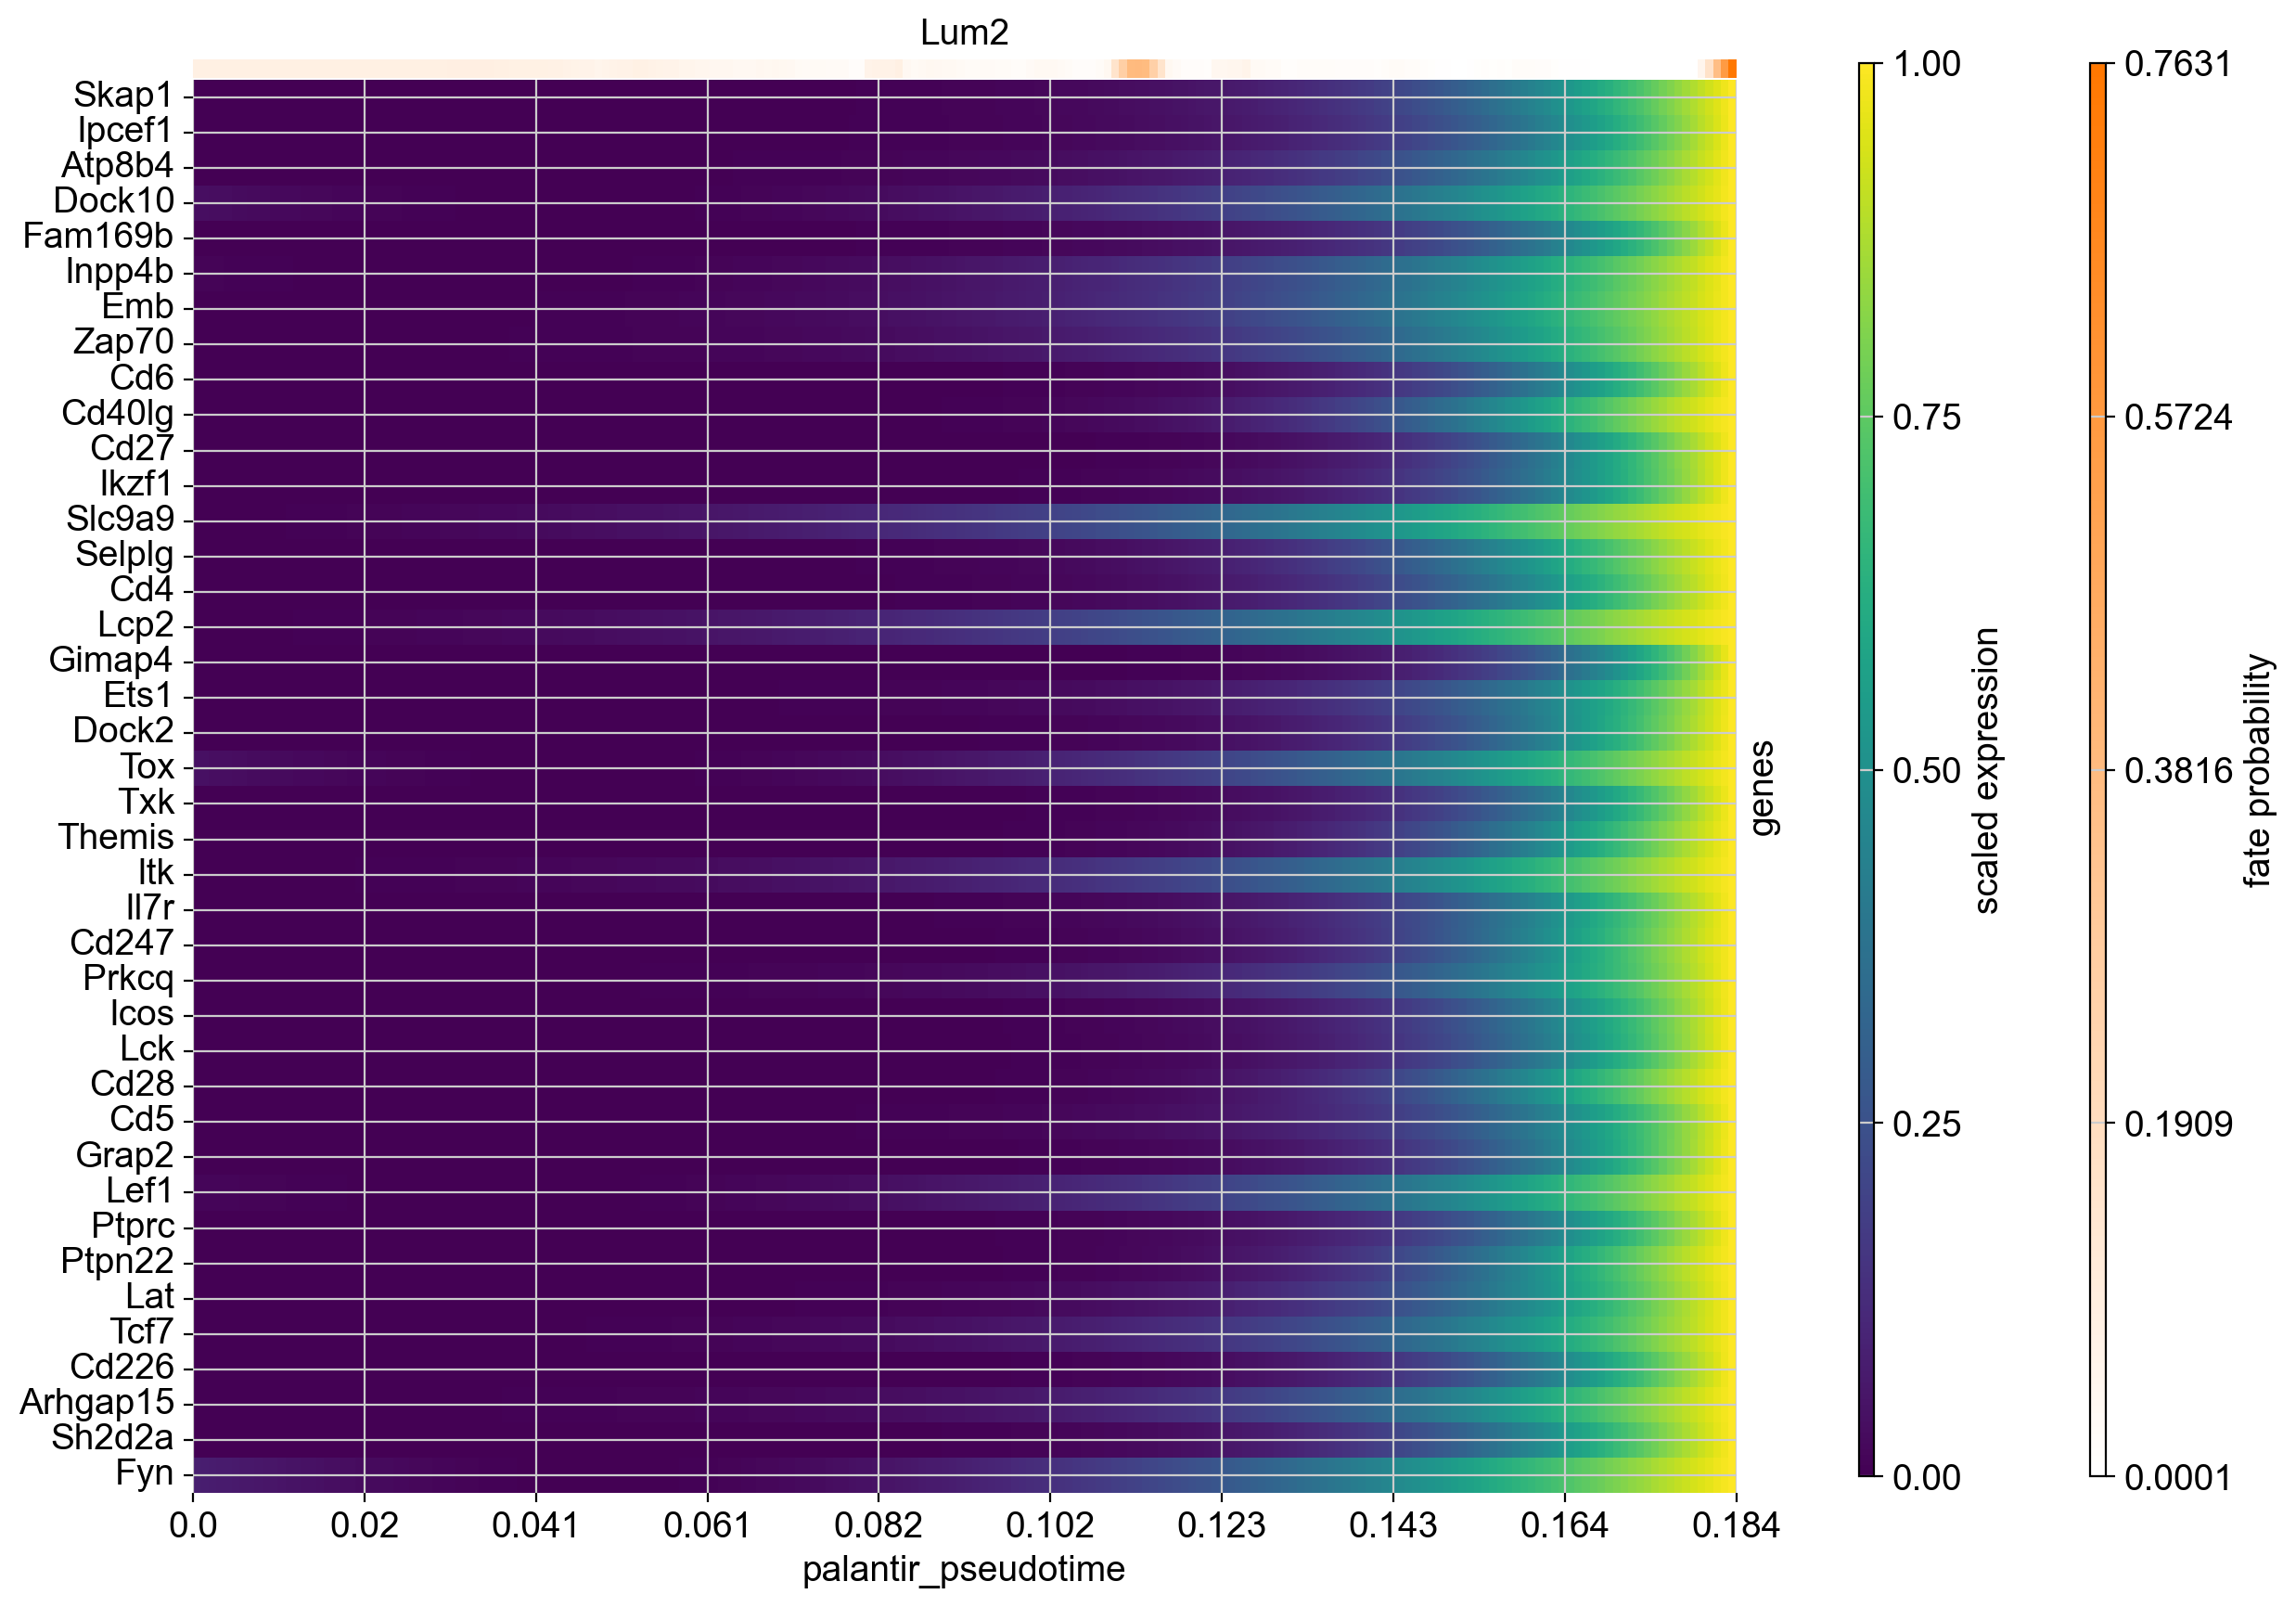

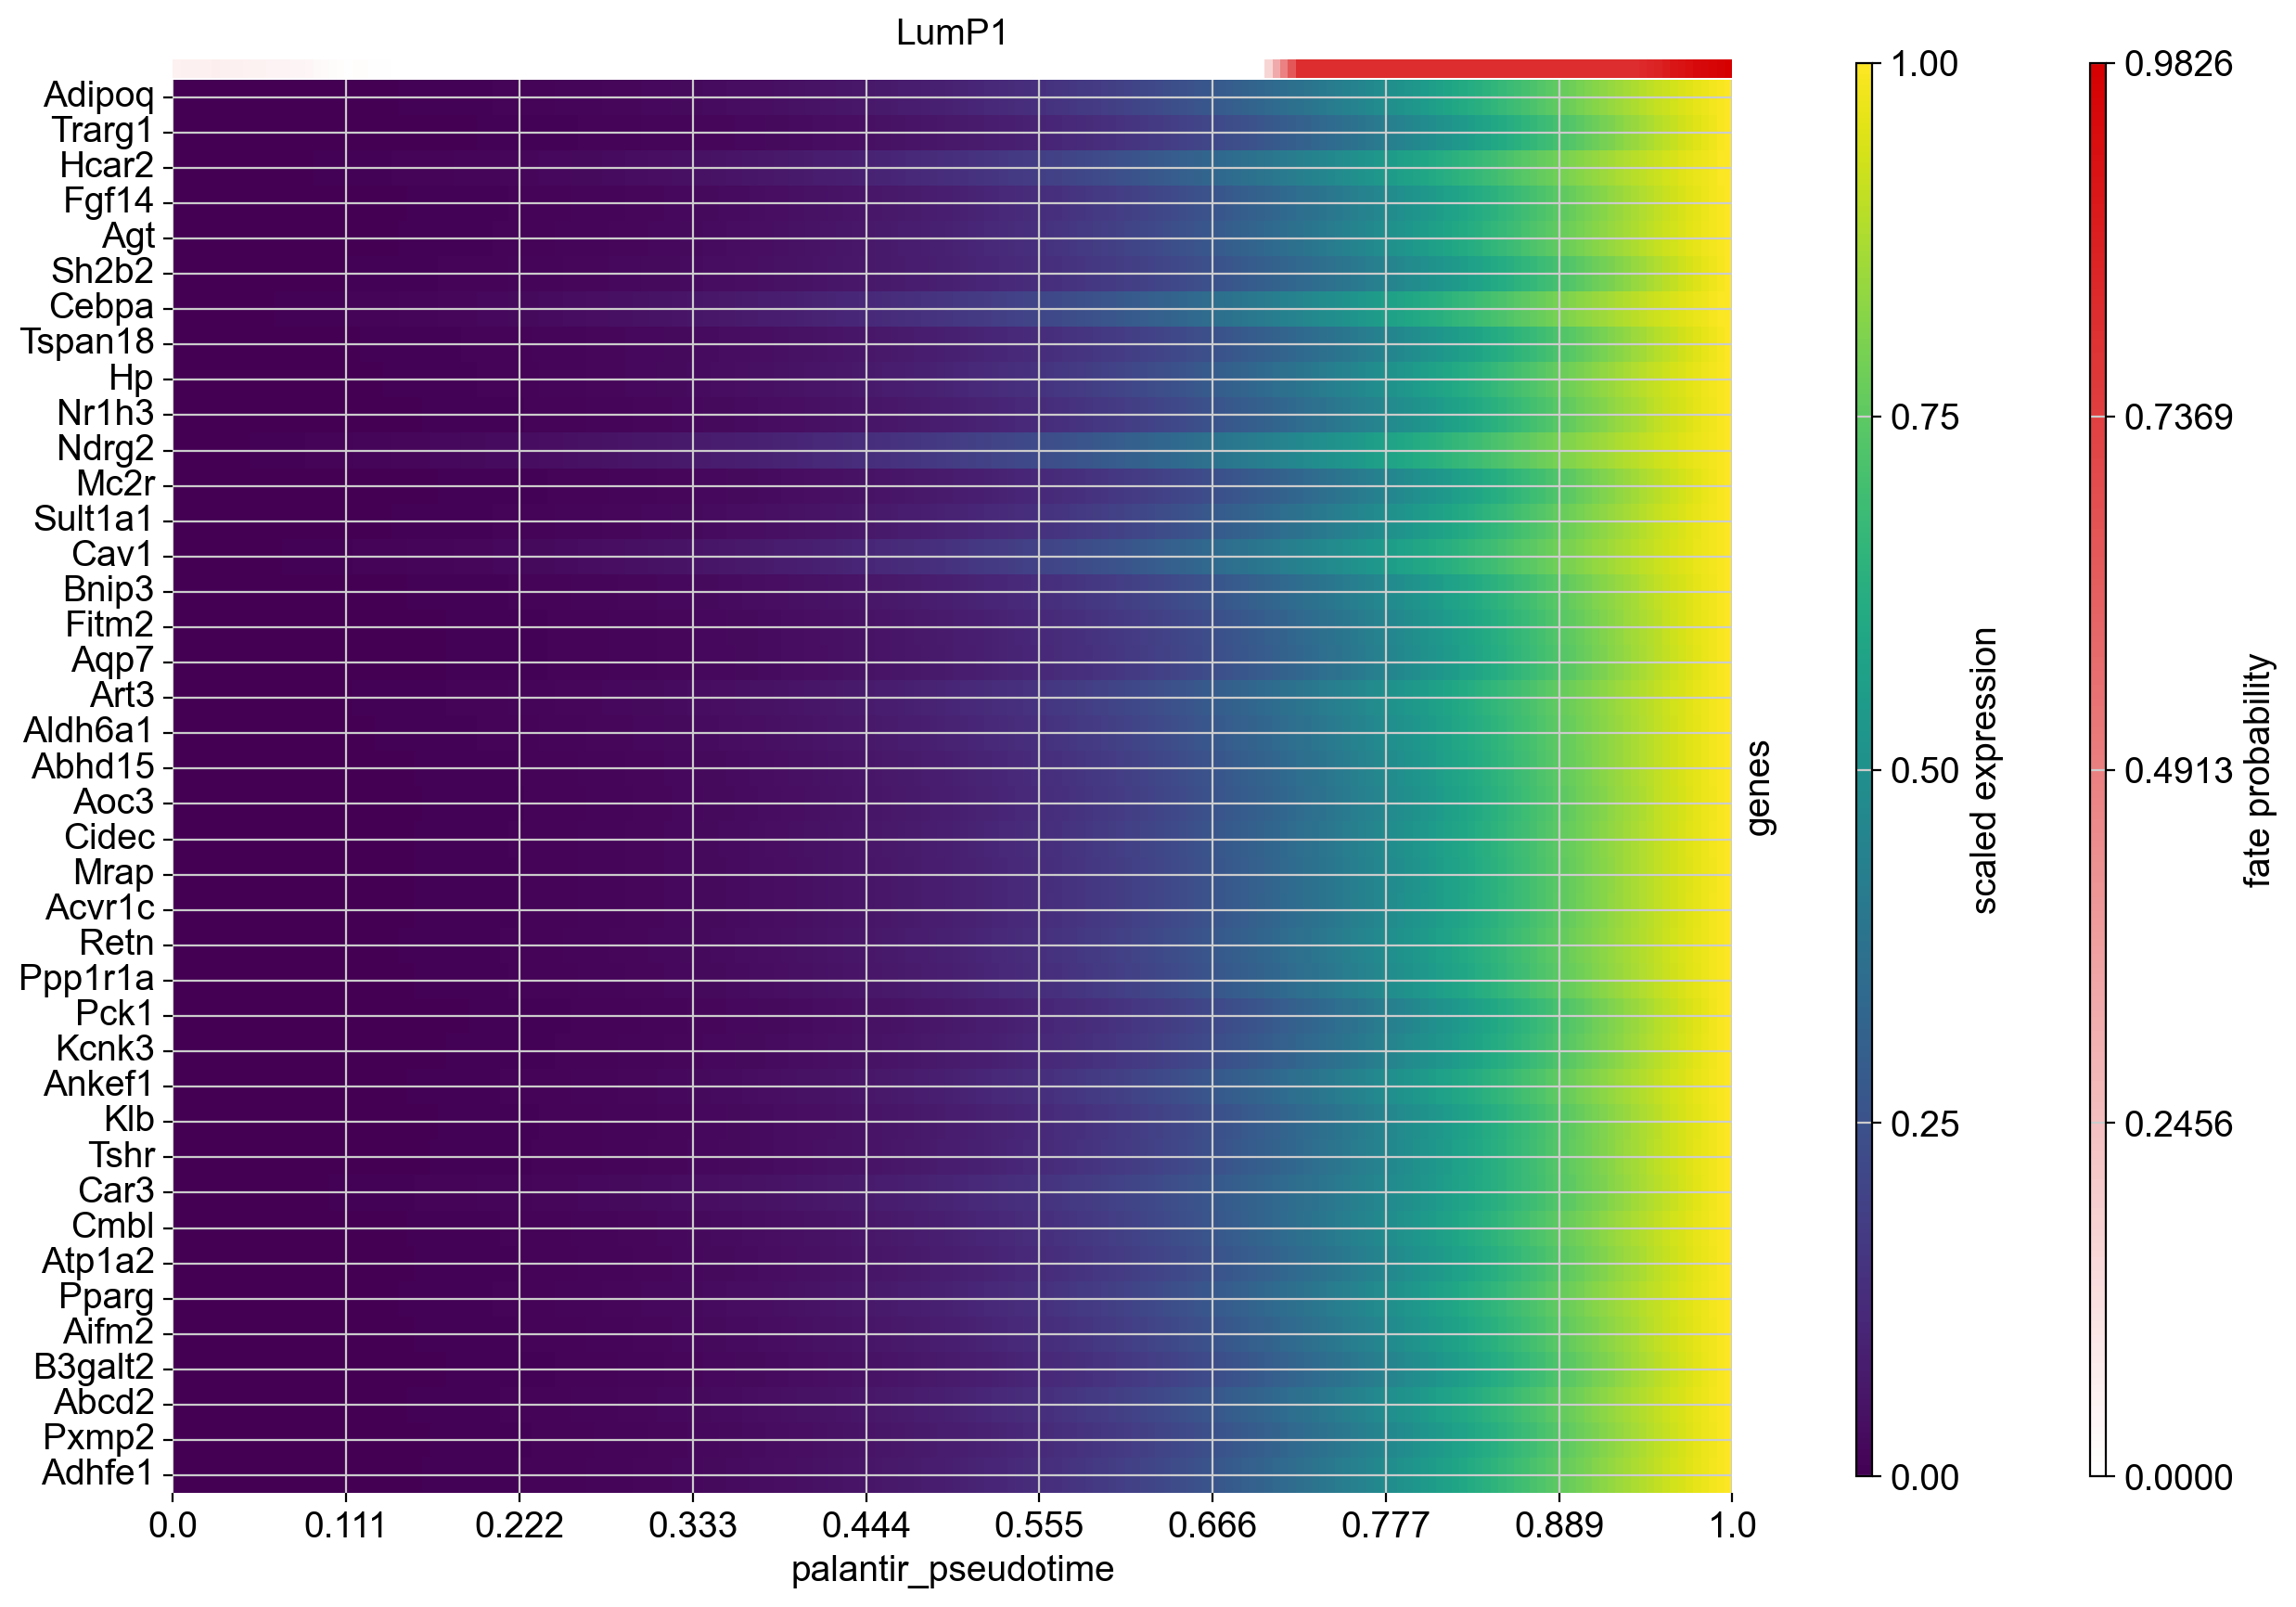

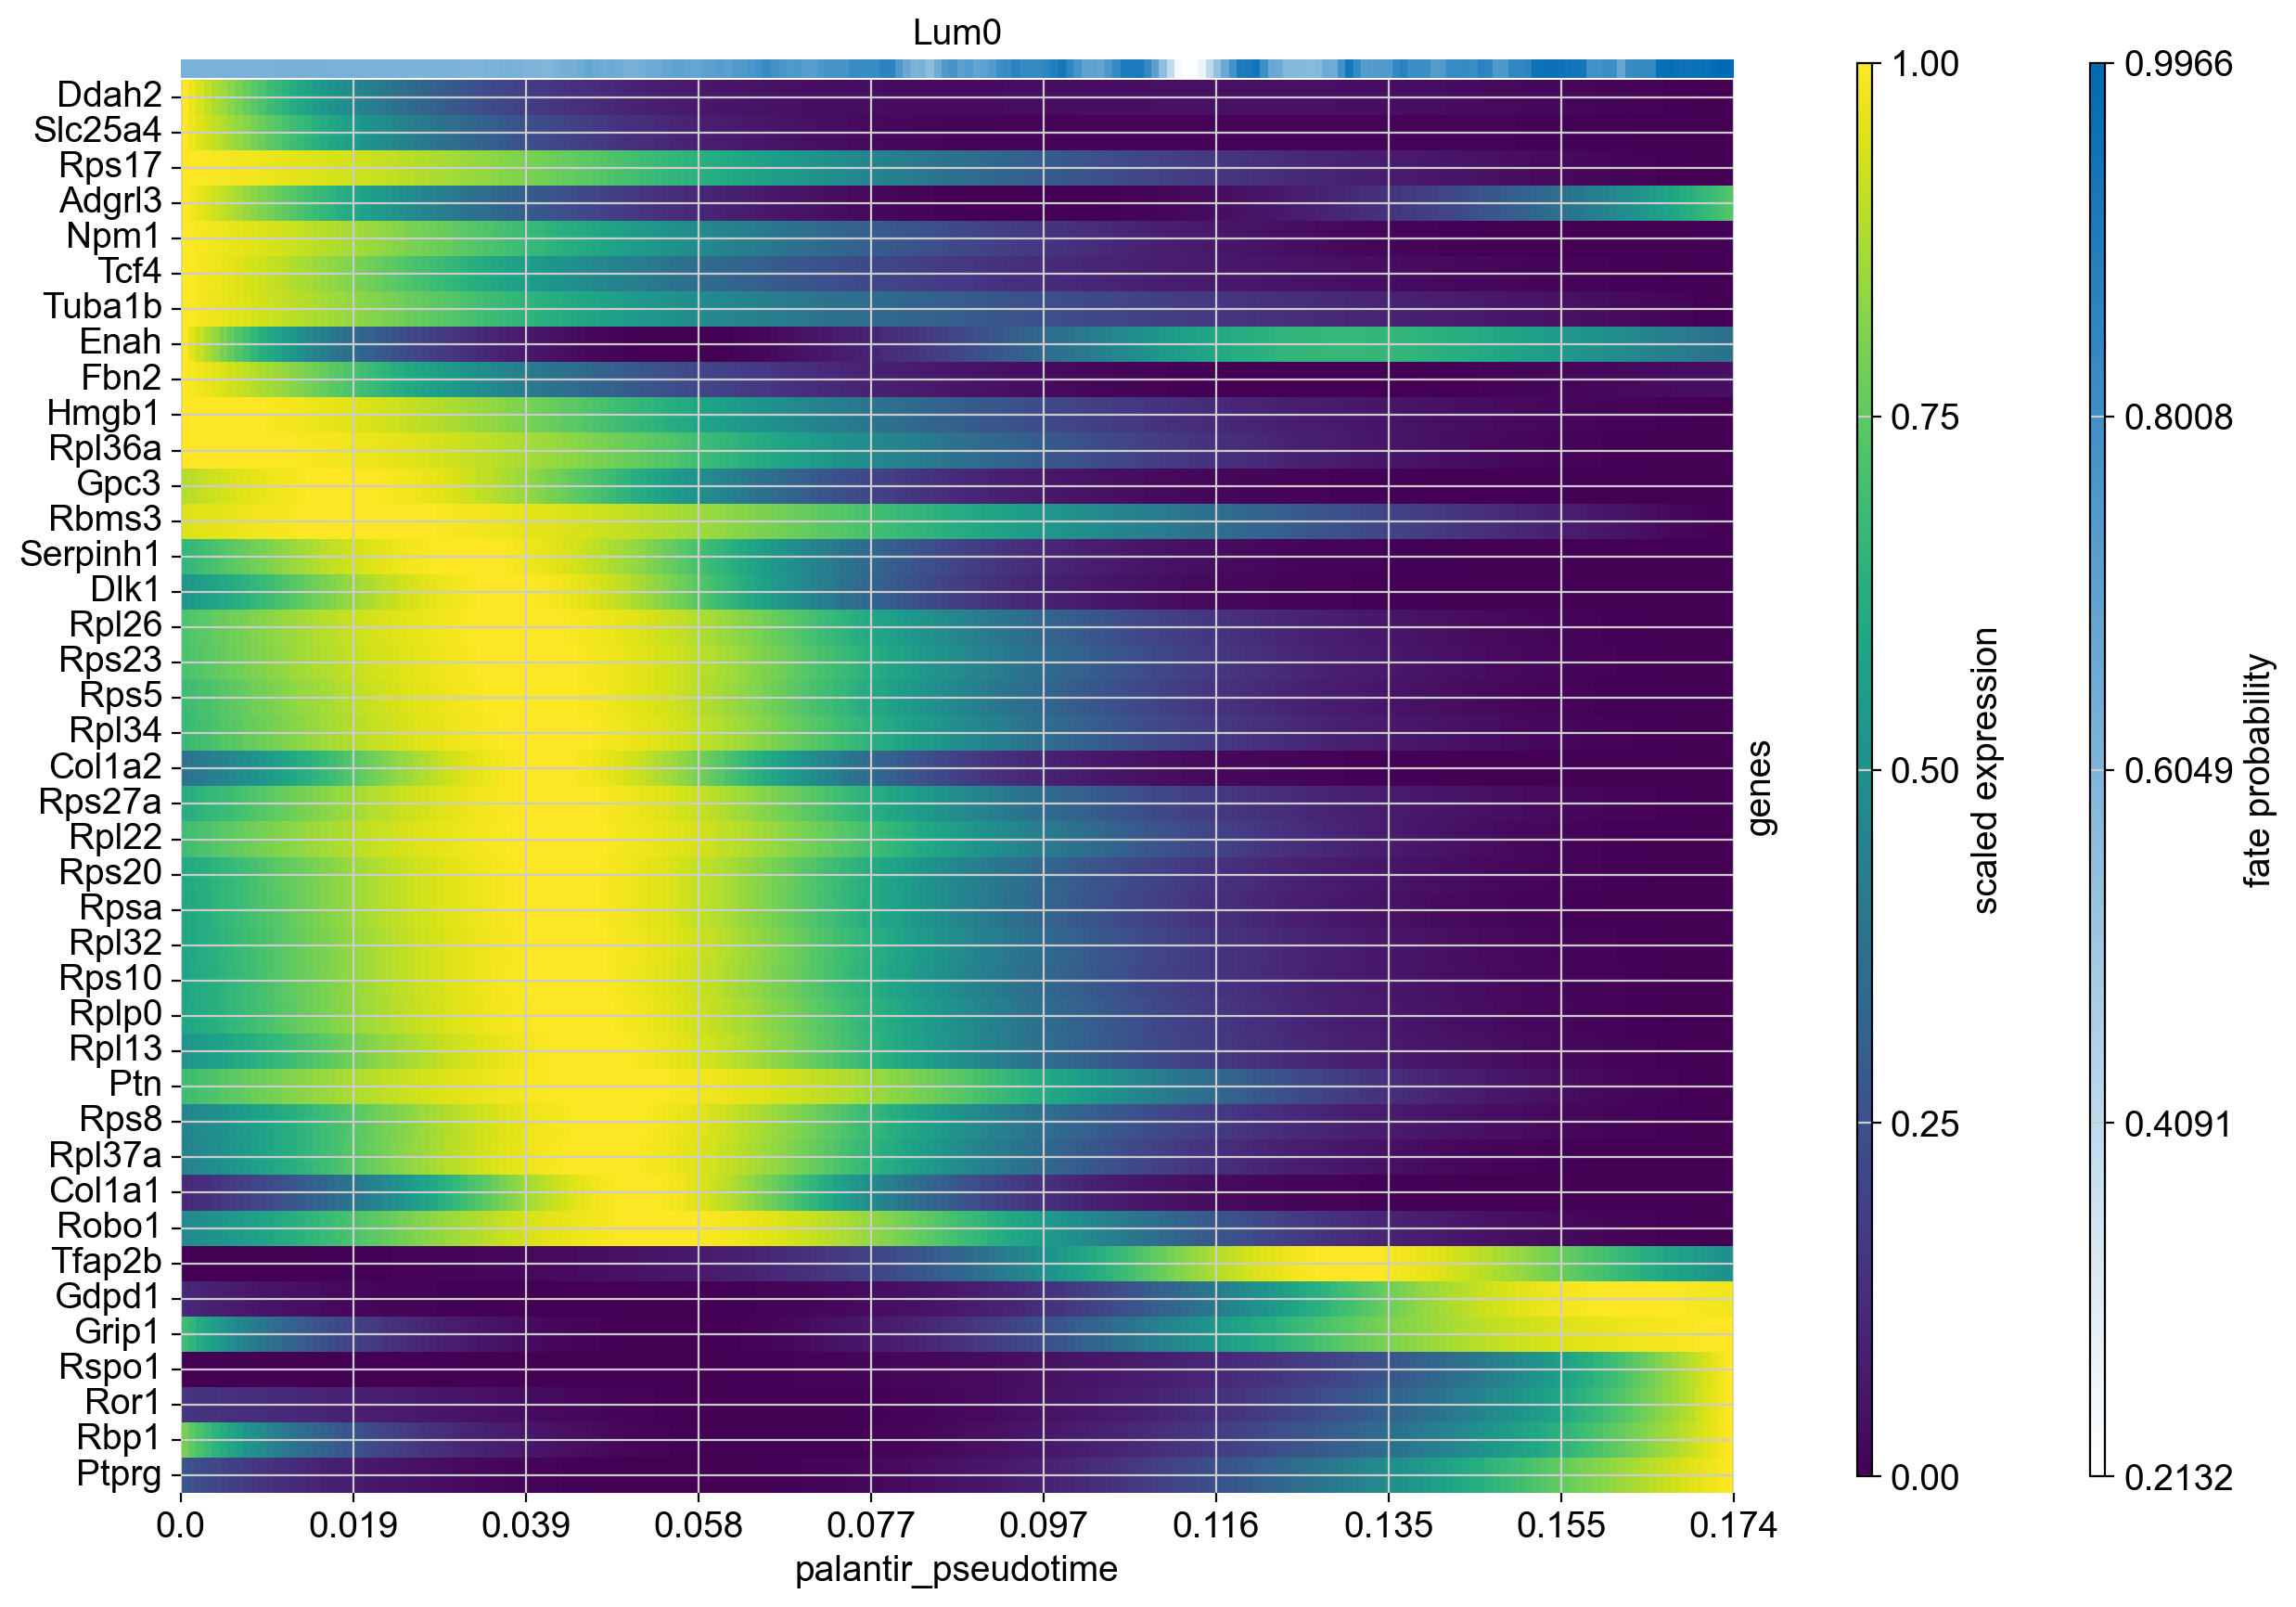

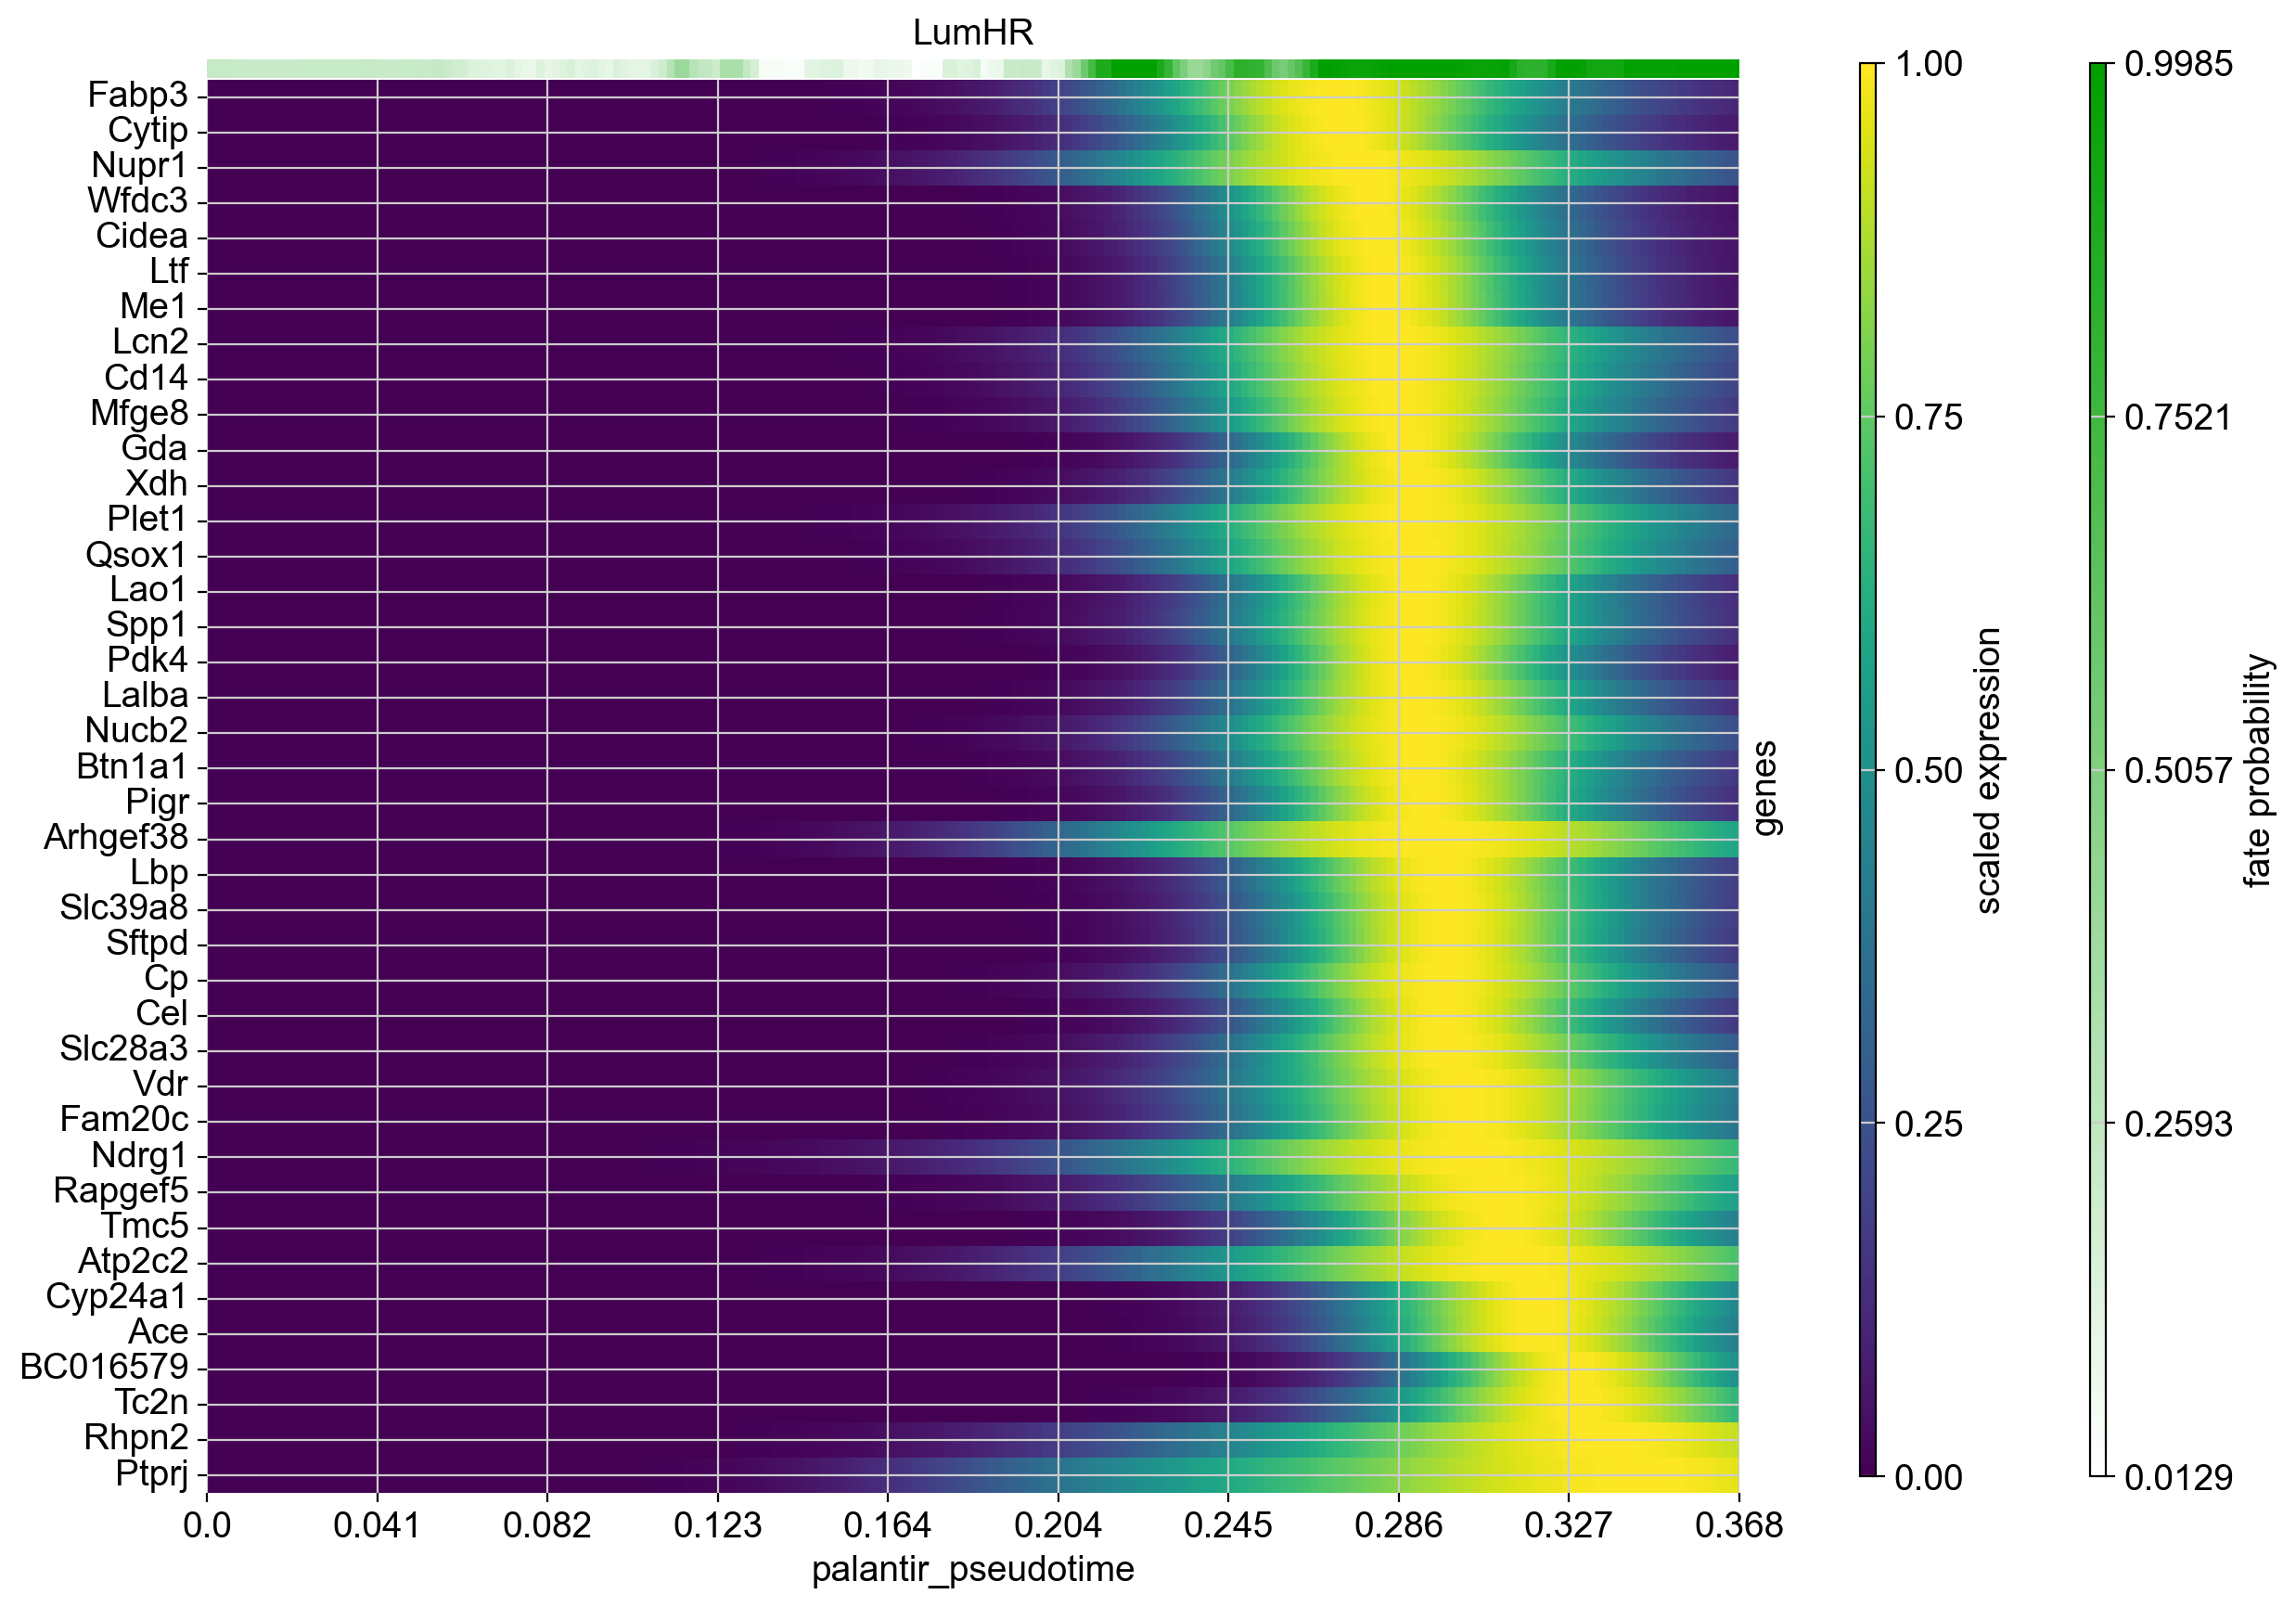

In [57]:
for cellname in terminal_states:
    
    cell_drivers = g.compute_lineage_drivers(lineages=cellname)
    cell_drivers.to_csv(f'{cellname}-driver-gene.csv')
    cr.pl.heatmap(
    adata_pala,
    model=model,  # use the model from before
    lineages=cellname,
    show_fate_probabilities=False,
    data_key="MAGIC_imputed_data",
    genes=cell_drivers.head(n_genes).index,
    time_key=pseudotime,
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
    n_jobs=cores,
    save=f'{dataset}-{cellname}-cr-heatmap.png'
    )
    cell_drivers.to_csv(f'{cellname}-driver-gene.csv')
